In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# STEP 1: Install Python 3.8 and create virtual environment
!sudo apt-get update
!sudo apt-get install -y python3.8 python3.8-venv python3.8-dev

# STEP 2: Create and activate the virtual environment
!python3.8 -m venv py38env
!py38env/bin/pip install --upgrade pip setuptools wheel

# STEP 3: Install compatible packages
!py38env/bin/pip install scikit-learn==0.24.2
!py38env/bin/pip install auto-sklearn
!py38env/bin/pip install openml
!py38env/bin/pip install  matplotlib seaborn
# !py38env/bin/pip install  pandas



Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [75.2 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,118 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 4.5 MB/s eta 0:00:00


In [19]:
# Code to save as Python script for execution
code = """
if __name__ == "__main__":
    import openml
    import autosklearn.classification
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import balanced_accuracy_score
    import numpy as np
    import pandas as pd
    import matplotlib
    matplotlib.use('Agg')  # ✅ Forces non-interactive backend for headless environment
    import matplotlib.pyplot as plt
    import os

    # Dataset IDs
    dataset_ids = [38, 554, 1049]
    variant_names = ['vanilla', 'ensemble_only', 'metalearning_only', 'metalearning_ensemble']
    results = {d_id: {} for d_id in dataset_ids}

    def run_automl(X_train, y_train, X_test, y_test, metalearning, ensemble):
        common_args = dict(
            time_left_for_this_task=300,
            per_run_time_limit=60,
            initial_configurations_via_metalearning=25 if metalearning else 0,
            seed=42,
            resampling_strategy='holdout',
            metric=autosklearn.metrics.balanced_accuracy
        )
        
        if not ensemble:
            automl = autosklearn.classification.AutoSklearnClassifier(
                ensemble_size=1,
                ensemble_nbest=1,
                **common_args
            )
        else:
            automl = autosklearn.classification.AutoSklearnClassifier(
                ensemble_size=50,
                ensemble_nbest=50,
                **common_args
            )

        automl.fit(X_train, y_train)
        y_pred = automl.predict(X_test)
        return 1 - balanced_accuracy_score(y_test, y_pred)  # BER

    # Run experiments
    for d_id in dataset_ids:
        dataset = openml.datasets.get_dataset(d_id)
        X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
        X_train = X_train.copy()
        X_test = X_test.copy()

        results[d_id]['vanilla'] = run_automl(X_train, y_train, X_test, y_test, metalearning=False, ensemble=False)
        results[d_id]['ensemble_only'] = run_automl(X_train, y_train, X_test, y_test, metalearning=False, ensemble=True)
        results[d_id]['metalearning_only'] = run_automl(X_train, y_train, X_test, y_test, metalearning=True, ensemble=False)
        results[d_id]['metalearning_ensemble'] = run_automl(X_train, y_train, X_test, y_test, metalearning=True, ensemble=True)

    # Analyze and visualize
    df_results = pd.DataFrame(results).T
    df_ranks = df_results.rank(axis=1, method='min')
    avg_ranks = df_ranks.mean().sort_values()

    print("Balanced Error Rates (BER):")
    print(df_results)
    print("Average Ranks:")
    print(avg_ranks)

    # Ensure plots directory exists
    os.makedirs("plots", exist_ok=True)

    # Save plot
    plt.figure(figsize=(8, 5))
    avg_ranks.plot(kind='bar', color='skyblue')
    plt.ylabel("Average Rank (lower is better)")
    plt.title("Average Rank of AutoSklearn Variants (Balanced Error Rate)")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig("plots/overall_micro_metrics.png")
    plt.show()


 

"""

# Save the code to a file
with open("autosklearn_test.py", "w") as f:
    f.write(code)

# Now run the script using your virtual environment
!py38env/bin/python autosklearn_test.py


autosklearn_test.py:30: DeprecationWarning: `ensemble_size` has been deprecated, please use `ensemble_kwargs = {'ensemble_size': 1}`. Inserting `ensemble_size` into `ensemble_kwargs` for now. `ensemble_size` will be removed in auto-sklearn 0.16.
  automl = autosklearn.classification.AutoSklearnClassifier(
/kaggle/working/py38env/lib/python3.8/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(
autosklearn_test.py:36: DeprecationWarning: `ensemble_size` has been deprecated, please use `ensemble_kwargs = {'ensemble_size': 50}`. Inserting `ensemble_size` into `ensemble_kwargs` for now. `ensemble_size` will be removed in auto-sklearn 0.16.
  automl = autosklearn.classification.AutoSklearnClassifier(
/kaggle/working/py38env/lib/python3.8/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitt

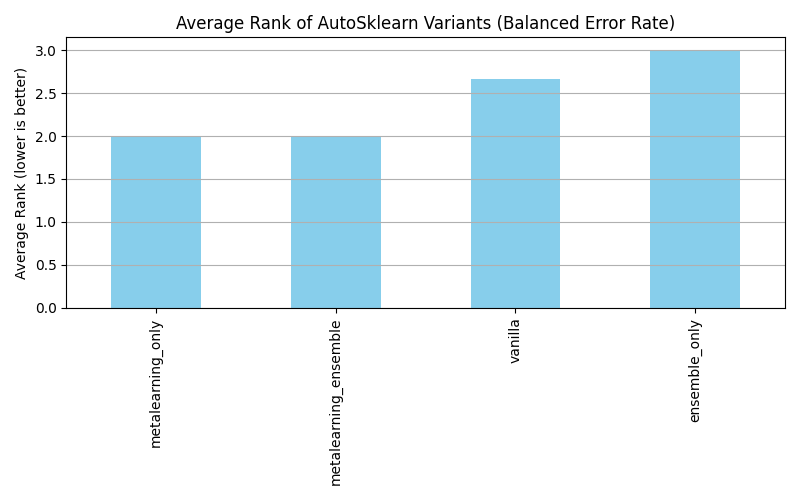

In [20]:
from IPython.display import Image, display
display(Image("plots/overall_micro_metrics.png"))


In [36]:
code="""
if __name__ == "__main__":
    import openml
    import autosklearn.classification
    from autosklearn.metrics import balanced_accuracy
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    import os

    dataset_id = 38
    time_limit = 1200     # 20 minutes total
    per_run_limit = 90    # 1.5 minutes per config


    variants = {
        'vanilla': {'metalearning': False, 'ensemble': False},
        'ensemble_only': {'metalearning': False, 'ensemble': True},
        'metalearning_only': {'metalearning': True, 'ensemble': False},
        'metalearning_ensemble': {'metalearning': True, 'ensemble': True}
    }

    os.makedirs("plots", exist_ok=True)
    all_results = {}

    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    X_train = X_train.copy()
    X_test = X_test.copy()

    for vname, config in variants.items():
        print("Training " + vname + "...")
        automl = autosklearn.classification.AutoSklearnClassifier(
            time_left_for_this_task=time_limit,
            per_run_time_limit=per_run_limit,
            initial_configurations_via_metalearning=25 if config['metalearning'] else 0,
            ensemble_kwargs={"ensemble_size": 50 if config['ensemble'] else 1},
            metric=balanced_accuracy,
            resampling_strategy='holdout',
            seed=42
        )
        automl.fit(X_train, y_train)

        results = automl.cv_results_
        if "mean_test_score" not in results or "mean_fit_time" not in results:
            print("cv_results_ missing keys for " + vname)
            continue

        df = pd.DataFrame({
            "time": results["mean_fit_time"],
            "ber": 1 - results["mean_test_score"]
        }).sort_values("time")

        print("📊 BER for " + vname + ":")
        for _, row in df.iterrows():
            print("Time: " + str(round(row["time"], 2)) + " sec | BER: " + str(round(row["ber"], 4)))

        all_results[vname] = df

    # Plot all curves
    plt.figure(figsize=(10, 6))
    color_map = {
        'vanilla': 'black',
        'ensemble_only': 'red',
        'metalearning_only': 'blue',
        'metalearning_ensemble': 'green'
    }

    for vname, df in all_results.items():
        plt.plot(df["time"], df["ber"], label=vname.replace("_", " + "), color=color_map[vname], linewidth=2)

    plt.xlabel("Time [sec]")
    plt.ylabel("Balanced Error Rate (BER)")
    plt.title("BER over Time (via cv_results_) for AutoSklearn Variants")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plots/ber_over_time_multi_variant.png")

    



"""


# Save the code to a file
with open("autosklearn_classifier_rank.py", "w") as f:
    f.write(code)

# Now run the script using your virtual environment
!py38env/bin/python autosklearn_classifier_rank.py



Training vanilla...
/kaggle/working/py38env/lib/python3.8/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(
^C
Process ForkProcess-1:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/kaggle/working/py38env/lib/python3.8/site-packages/autosklearn/util/logging_.py", line 317, in start_log_server
    receiver.serve_until_stopped()
  File "/kaggle/working/py38env/lib/python3.8/site-packages/autosklearn/util/logging_.py", line 347, in serve_until_stopped
    rd, wr, ex = select.select([self.socket.fileno()], [], [], self.timeout)
KeyboardInterrupt


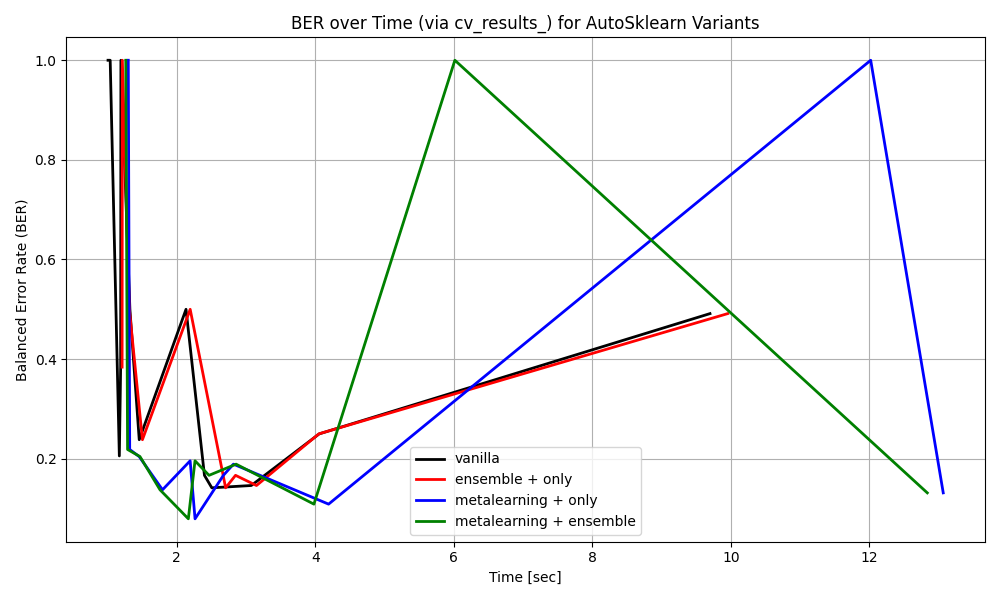

In [35]:

from IPython.display import Image, display
display(Image("plots/ber_over_time_multi_variant.png"))


In [40]:
code="""
if __name__ == "__main__":
    import openml
    import autosklearn.classification
    from autosklearn.metrics import balanced_accuracy
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    import os

    # === Config ===
    dataset_ids = [38, 554, 1049]
    time_limit = 900  # total budget per variant per dataset
    per_run_limit = 90
    timestamps = list(range(10, time_limit + 1, 10))  # time checkpoints

    variants = {
        'vanilla': {'metalearning': False, 'ensemble': False},
        'ensemble_only': {'metalearning': False, 'ensemble': True},
        'metalearning_only': {'metalearning': True, 'ensemble': False},
        'metalearning_ensemble': {'metalearning': True, 'ensemble': True}
    }

    os.makedirs("plots", exist_ok=True)
    all_ranks = {v: [] for v in variants}

    for d_id in dataset_ids:
        print("=== Dataset", d_id, "===")
        dataset = openml.datasets.get_dataset(d_id)
        X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, stratify=y, test_size=0.3, random_state=42)
        X_train = X_train.copy()
        X_test = X_test.copy()

        ber_curves = {}

        for vname, config in variants.items():
            print("▶ Training:", vname)
            automl = autosklearn.classification.AutoSklearnClassifier(
                time_left_for_this_task=time_limit,
                per_run_time_limit=per_run_limit,
                initial_configurations_via_metalearning=25 if config['metalearning'] else 0,
                ensemble_kwargs={"ensemble_size": 50 if config['ensemble'] else 1},
                metric=balanced_accuracy,
                resampling_strategy='holdout',
                seed=42
            )
            automl.fit(X_train, y_train)

            results = automl.cv_results_
            if "mean_test_score" not in results or "mean_fit_time" not in results:
                print("⚠ cv_results_ missing keys for", vname)
                continue

            df = pd.DataFrame({
                "time": results["mean_fit_time"],
                "ber": 1 - results["mean_test_score"]
            }).sort_values("time")

            interp = np.interp(timestamps, df["time"], df["ber"], left=np.nan, right=np.nan)
            ber_curves[vname] = interp

        for i, t in enumerate(timestamps):
            values_at_t = {v: ber_curves[v][i] for v in ber_curves if not np.isnan(ber_curves[v][i])}
            if len(values_at_t) < len(variants):
                continue
            series = pd.Series(values_at_t)
            ranked = series.rank(method="min")
            for v in ranked.index:
                all_ranks[v].append(ranked[v])

    # === Plot average rank over time ===
    plt.figure(figsize=(10, 6))
    color_map = {
        'vanilla': 'black',
        'ensemble_only': 'red',
        'metalearning_only': 'blue',
        'metalearning_ensemble': 'green'
    }

    # Compute and plot average rank curves
    for v in variants:
        ranks = all_ranks[v]
        n_points = len(ranks)
        averaged = pd.Series(ranks).groupby(np.arange(n_points) // len(dataset_ids)).mean()
        plt.plot(timestamps[:len(averaged)], averaged, label=v.replace("_", " + "), color=color_map[v], linewidth=2)

    plt.xlabel("Time [sec]")
    plt.ylabel("Average Rank (lower is better)")
    plt.title("Average Rank Over Time (AutoSklearn Variants Across 3 Datasets)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plots/average_rank_over_time_multi_dataset.png")
"""

# Save the code to a file
with open("autosklearn_classifier_rank.py", "w") as f:
    f.write(code)

# Now run the script using your virtual environment
!py38env/bin/python autosklearn_classifier_rank.py

=== Dataset 38 ===
▶ Training: vanilla
/kaggle/working/py38env/lib/python3.8/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(
▶ Training: ensemble_only
/kaggle/working/py38env/lib/python3.8/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(
▶ Training: metalearning_only
/kaggle/working/py38env/lib/python3.8/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(
▶ Training: metalearning_ensemble
/kaggle/working/py38env/lib/python3.8/site-packag

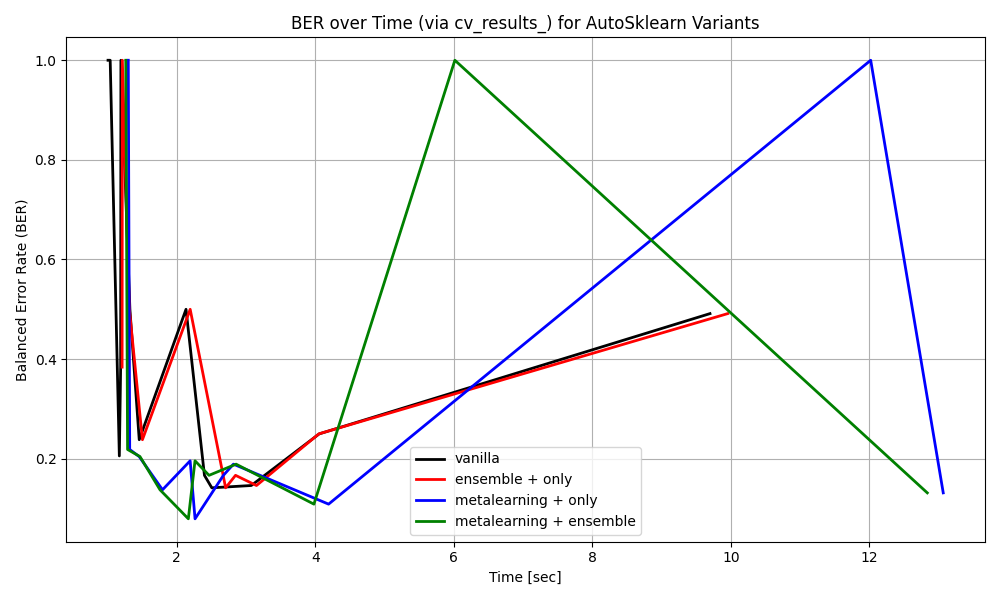

In [41]:

from IPython.display import Image, display
display(Image("plots/ber_over_time_multi_variant.png"))
